# Demonstrates how to compute Kernel Feedbacks with a couple of options for normalization

The code is described here (do not clone it!) https://github.com/tyfolino/climkern

I've repeated the climkern instructions to make an python environment that has the climkern package. I've enhanced it to make figures, etc. here. You'll likely first need to module load conda as I've shown here. I ran these commands from $WORK/conda-envs but I don't think it matters. Be sure to do these steps one at a time, waiting between and answering "y" as needed:

    module load conda
    conda create -n ck_env python=3.10 esmpy -c conda-forge
    conda activate ck_env
    pip install ipykernel
    pip install matplotlib
    pip install cartopy
    pip install climkern
    python -m ipykernel install --user --name=ck_env

Once installed, ClimKern requires kernels found on Zenodo. These kernels and tutorial data total >5GB so this takes about 12 min. You can do ONE of the following

    1) Make a soft link to the data in my directory

    cd $WORK/conda-envs/ck_env/lib/python3.10/site-packages/climkern
    ln -s /glade/work/bitz/conda-envs/ck_env/lib/python3.10/site-packages/climkern/data
    cd $WORK/conda-envs/

    OR 2) get the data yourself (either copy it from my directory which is a bit faster) or get it from Zenodo yourself:

    python -m climkern download

The original author offers a pytest that is optional. It takes a few minutes and then it gave me a warning "Expected 16 from C header, got 96 from PyObject". So far it hasn't seemed to matter, so I don't think you need to bother with it. But if you do install it, you'll need to run it using the full path. It gets installed in  $WORK/conda-envs/ck_env/bin/pytest


# You'll need to select the ck_env kernel environment to run this script. I had to close and shutdown the notebook and re-open it, then change kernel to ck_env

To use the code, I found the documentation on github helpful but kind of incomplete. I found the documentation in the following code helpful that I've repeated here:

From $WORK/conda-envs/ck_env/lib/python3.10/site-packages/climkern/frontend.py

def calc_alb_feedback(
    ctrl_rsus: DataArray,
    ctrl_rsds: DataArray,
    pert_rsus: DataArray,
    pert_rsds: DataArray,
    kern: str = "GFDL",
    sky: str = "all-sky",
) -> DataArray:

    Calculate the radiative perturbation (W/m^2) from changes in surface                                                                              
    albedo using user-specified radiative kernel. Horizontal resolution                                                                               
    is kept at input data's resolution.                                                                                                               
                                                                                                                                                      
    Parameters                                                                                                                                        
    ----------                                                                                                                                        
    ctrl_rsus : xarray DataArray                                                                                                                      
        DataArray containing the upwelling SW radiation at the surface in the                                                                         
        control simulation. Must be 3D with coordinates of time, latitude, and                                                                        
        longitude with units of W/m^2.                                                                                                                
                                                                                                                                                      
    ctrl_rsds : xarray DataArray                                                                                                                      
        DataArray containing the downwelling SW radiation at the surface in                                                                           
        the control simulation. Must be 3D with coordinates of time, latitude,                                                                        
        and longitude with units of W/m^2.                                                                                                            
                                                                                                                                                      
    pert_rsus : xarray DataArray                                                                                                                      
        DataArray containing the upwelling SW radiation at the surface in the                                                                         
        perturbed simulation. Must be 3D with coordinates of time, latitude,                                                                          
        and longitude with units of W/m^2.                                                                                                            
                                                                                                                                                      
    pert_rsds : xarray DataArray                                                                                                                      
        DataArray containing the downwelling SW radiation at the surface in                                                                           
        the perturbed simulation. Must be 3D with coordinates of time,                                                                                
        latitude, and longitude with units of W/m^2.                                                                                                  
                                                                                                                                                      
    kern : string, optional                                                                                                                           
        String specifying the name of the desired kernel. Defaults to "GFDL".                                                                         
                                                                                                                                                      
    sky : string, optional                                                                                                                            
        String, either "all-sky" or "clear-sky", specifying whether to                                                                                
        calculate the all-sky or clear-sky feedbacks. Defaults to "all-sky".                                                                          
                                                                                                                                                      
    Returns                                                                                                                                           
    -------                                                                                                                                           
    alb_feedback : xarray DataArray                                                                                                                   
        3D DataArray containing radiative perturbations at TOA caused by                                                                              
        changes in surface albedo with coordinates of time, latitude, and                                                                             
        longitude.                                                                                                                                    

Finally there are some definitions used in this code. I've taken them from Smith et al (2020) https://acp.copernicus.org/articles/20/9591/2020/acp-20-9591-2020.pdf

Effective radiative forcing (ERF) is the TOM flux difference between a perturbed and control FixedSST simulations $\Delta$ FLNT - $\Delta$ FSNT, with no correction for land surface temperature change.

Effective radiative forcing using a Gregory regression (ERF_reg). ERF_reg is calculated from the perturbed fully-coupled simulation from extrapolating the Gregory Plot back to the y-axis intercept using the first 30 years of output. The piControl fully-coupled simulation has essentially zero net flux at TOM so we don't have to remove it.

Instantaneous forcing (IRF) is calculated as the difference of the ERF and the sum of adjustments

Adjustments Ax = Kx(xpert−xbase) where x = atmospheric state variable (air temperature, surface temperature, specific humidity or surface albedo)

If not provided, ClimKern will assume a tropopause height of            
        300 hPa at the equator, linearly decreasing with the cosine of                  
        latitude to 100 hPa at the poles.

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors

# Data manipulation
import climkern as ck
import pandas as pd
import numpy as np
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ctrl,pert = ck.tutorial_data('ctrl'),ck.tutorial_data('pert')

In [4]:
ctrl

<xarray.Dataset> Size: 398MB
Dimensions:  (plev: 30, lat: 192, lon: 288, time: 12)
Coordinates:
  * plev     (plev) float64 240B 364.3 759.5 1.436e+03 ... 9.763e+04 9.926e+04
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/17)
    Q        (time, plev, lat, lon) float64 159MB ...
    T        (time, plev, lat, lon) float64 159MB ...
    TS       (time, lat, lon) float64 5MB ...
    FLNS     (time, lat, lon) float64 5MB ...
    FLNSC    (time, lat, lon) float64 5MB ...
    FLNT     (time, lat, lon) float64 5MB ...
    ...       ...
    FSDS     (time, lat, lon) float64 5MB ...
    FSNT     (time, lat, lon) float64 5MB ...
    FSNTC    (time, lat, lon) float64 5MB ...
    TROP_P   (time, lat, lon) float64 5MB ...
    PS       (time, lat, lon) float64 5MB ...
    FSUS     (time, lat, lon) float64 5MB ...

In [5]:
LR,Planck = ck.calc_T_feedbacks(ctrl.T,ctrl.TS,ctrl.PS,
                                pert.T,pert.TS,pert.PS,pert.TROP_P,
                                kern="GFDL")

In [6]:
Albedo = ck.calc_alb_feedback(ctrl.FSUS, ctrl.FSDS, 
                               pert.FSUS, pert.FSDS,
                                kern="GFDL")

In [7]:
lw_q, sw_q = ck.calc_q_feedbacks(ctrl.Q,ctrl.T,ctrl.PS,
                                pert.Q,pert.PS,pert.TROP_P,
                                kern="GFDL")

In [8]:
dCRE_SW = ck.calc_dCRE_SW(ctrl.FSNT, pert.FSNT, ctrl.FSNTC, pert.FSNTC)
dCRE_LW = ck.calc_dCRE_LW(ctrl.FLNT, pert.FLNT, ctrl.FLNTC, pert.FLNTC)

In [9]:
dTS_glob_avg = ck.spat_avg(pert.TS - ctrl.TS)

In [ ]:
IRF = ck.tutorial_data('IRF')

In [16]:
IRF

<xarray.Dataset> Size: 11MB
Dimensions:   (lon: 288, lat: 192, time: 12)
Coordinates:
  * lon       (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time      (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    IRF_lwas  (time, lat, lon) float32 3MB ...
    IRF_lwcs  (time, lat, lon) float32 3MB ...
    IRF_swas  (time, lat, lon) float32 3MB ...
    IRF_swcs  (time, lat, lon) float32 3MB ...
Attributes:
    long_name:  net downward flux
    units:      wm-2
    title:      net downward flux

In [17]:
pert.TROP_P

<xarray.DataArray 'TROP_P' (time: 12, lat: 192, lon: 288)> Size: 5MB
array([[[25826.833073, 25826.832292, ..., 25826.833073, 25826.832357],
        [25825.353516, 25826.45651 , ..., 25823.545768, 25824.492513],
        ...,
        [22086.377539, 22087.969401, ..., 22086.081966, 22086.323568],
        [22220.557878, 22220.557878, ..., 22220.557812, 22220.557878]],

       [[26359.19388 , 26359.192578, ..., 26359.194596, 26359.192578],
        [26365.23724 , 26366.117773, ..., 26363.594596, 26364.369922],
        ...,
        [22002.362044, 21994.237826, ..., 22007.178516, 22006.21569 ],
        [22010.908073, 22010.908138, ..., 22010.908073, 22010.908073]],

       ...,

       [[20300.831445, 20300.830078, ..., 20300.831901, 20300.829948],
        [20230.912956, 20231.101172, ..., 20231.800911, 20231.288216],
        ...,
        [22920.835612, 22918.388021, ..., 22925.641862, 22923.238932],
        [22970.188607, 22970.188672, ..., 22970.188607, 22970.188607]],

       [[23738.443294, 23738.444076, ..., 23738.442904, 23738.444076],
        [23726.669466, 23726.254232, ..., 23727.919987, 23727.143359],
        ...,
        [22398.034375, 22395.800065, ..., 22404.072526, 22401.292578],
        [22488.613477, 22488.613477, ..., 22488.613346, 22488.613346]]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Tropopause Height
    units:      Pa
    run::       abrupt2xCO2
    model:      CESM1-LENS

In [10]:
# individual plots
def plotprojection(field,title):
    # Create figure with PlateCarree projection
    projection = ccrs.Robinson(central_longitude=0)
    transform = ccrs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(1, 1, figsize=(2.2, 1.5), 
        subplot_kw=dict(projection=projection),
        dpi=300)
    mesh = axs.pcolormesh(field.lon.data, field.lat.data, 
                             field.data, cmap='coolwarm',
                             transform=transform, vmin=-4.5, vmax=4.5)
    cbar = plt.colorbar(mesh, ax=axs, orientation='horizontal', shrink=0.95, pad=0.05)
    #cbar.set_label(f'Lapse Rate Adjustment \n in $W m^{-2}$',size=6)
    cbar.set_label(title,size=4)
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_xscale('linear')
    axs.coastlines()
    return

def plotAllFB(ddict,fields,title):
    projection = ccrs.Robinson(central_longitude=0)
    transform = ccrs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(3, 2, figsize=(5, 5), 
        subplot_kw=dict(projection=projection),
        dpi=300)
    axs = axs.reshape(-1)
    i=0
    for thevar in fields:
        field = ddict[thevar]
        mesh = axs[i].pcolormesh(field.lon.data, field.lat.data, 
                                 field.data, cmap='coolwarm', vmin=-4.5, vmax=4.5,
                                 transform=transform)
        axs[i].coastlines()
        axs[i].set_title(thevar,size=4)
        i=i+1
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.23, 0.12,  0.6, 0.02])
    cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal', shrink=0.95, pad=0.05)
    cbar.set_label(title,size=5)
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_xscale('linear')
    return

In [11]:
fields=['LR','Planck','Albedo','WV','CRE_SW','CRE_LW']

ddict = {}
ddict['LR'] = LR.mean(dim='time')/dTS_glob_avg.mean(dim='time')
ddict['Planck'] = Planck.mean(dim='time')/dTS_glob_avg.mean(dim='time')
ddict['Albedo'] = Albedo.mean(dim='time')/dTS_glob_avg.mean(dim='time')
ddict['WV'] = (sw_q+lw_q).mean(dim='time')/dTS_glob_avg.mean(dim='time')
ddict['CRE_SW'] = dCRE_SW.mean(dim='time')
ddict['CRE_LW'] = dCRE_LW.mean(dim='time')

The figure shows Lapse Rate, Planck, Albedo, Water Vapor Feedbacks and Cloud Radiative Effect Change from control to perturbation

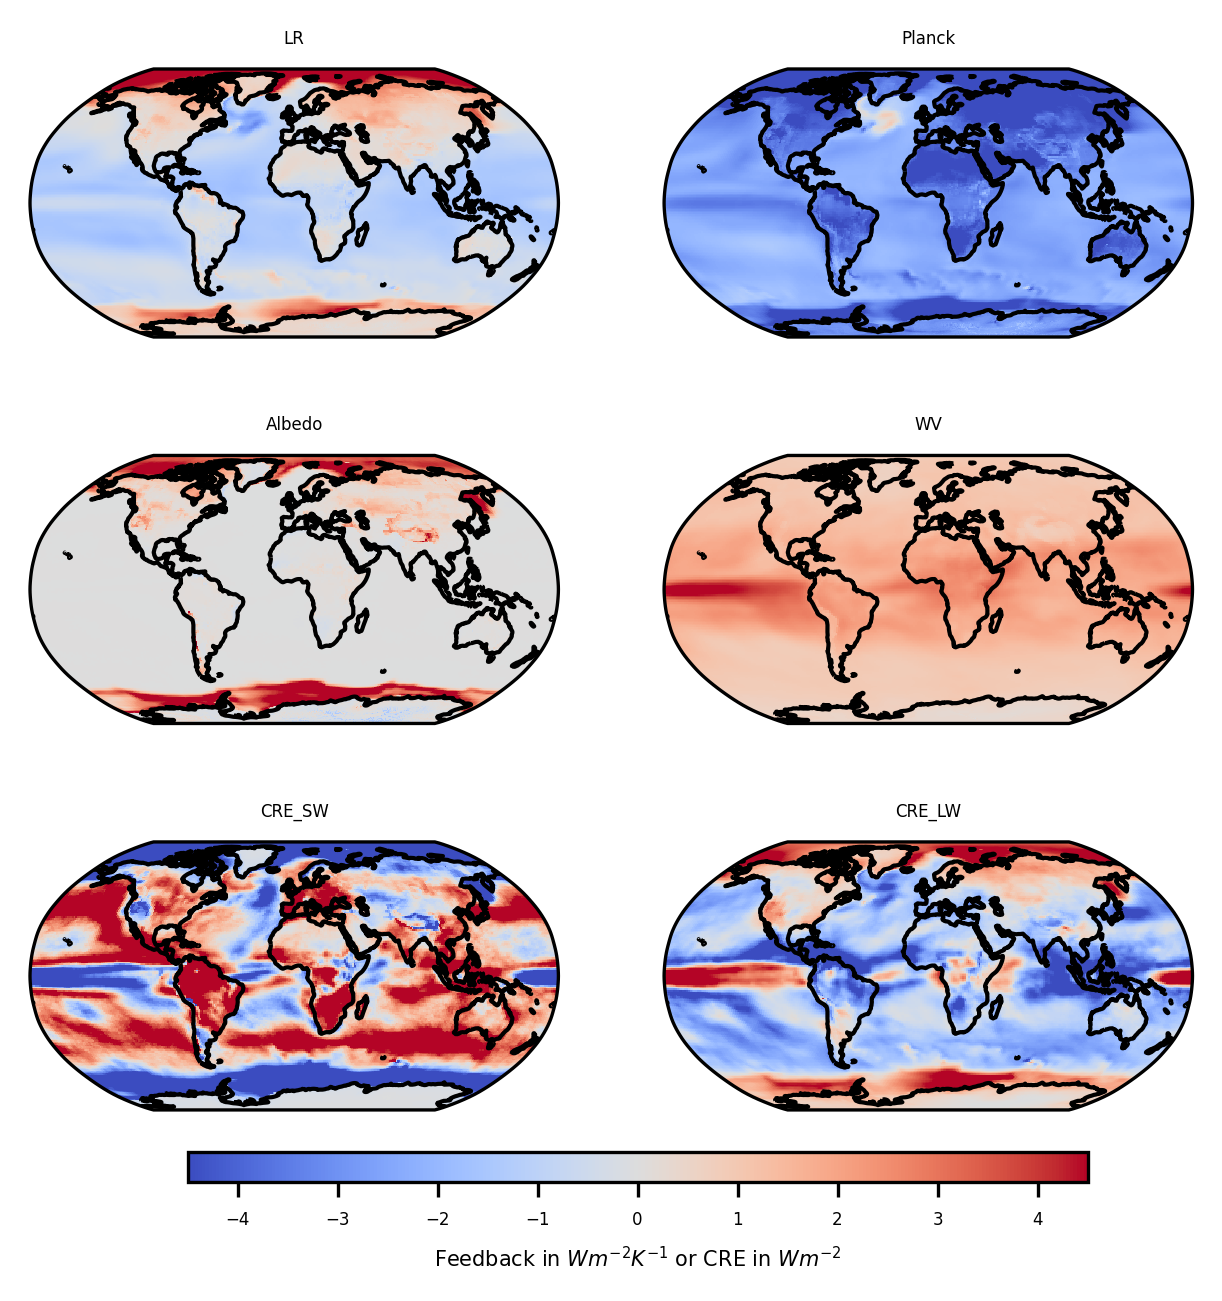

In [12]:
plotAllFB(ddict,fields,'Feedback in $W m^{-2}K^{-1}$ or CRE in $W m^{-2}$')
#plt.savefig('XXXX.png') # uncomment to save a copy of this figure, etc

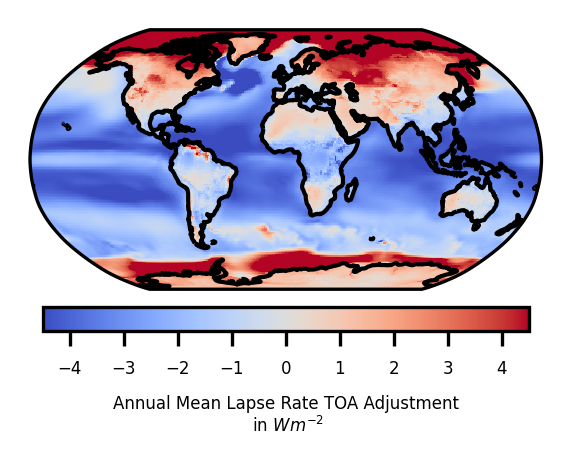

In [12]:
field=LR.mean(dim='time')
title='Annual Mean Lapse Rate TOA Adjustment\n in $W m^{-2}$'
plotprojection(field,title)
#plt.savefig('XXXX.png') # uncomment to save a copy of this figure, etc

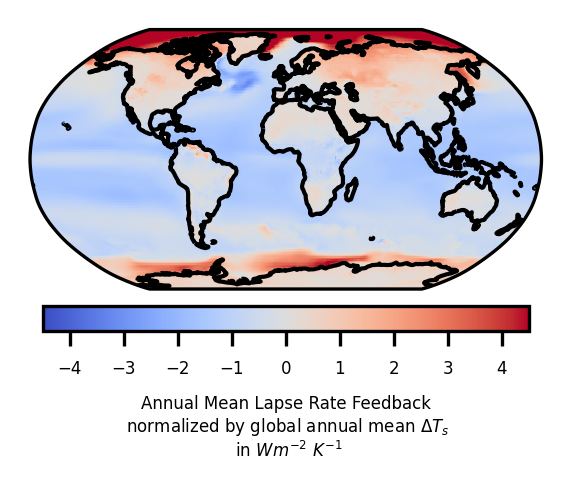

In [13]:
# how to normalize by temperature is debated, here we'll use global annual mean delta T
field=LR.mean(dim='time')/dTS_glob_avg.mean(dim='time')
title='Annual Mean Lapse Rate Feedback\n normalized by global annual mean $\Delta T_s$\n in $W m^{-2}~K^{-1}$'
plotprojection(field,title)

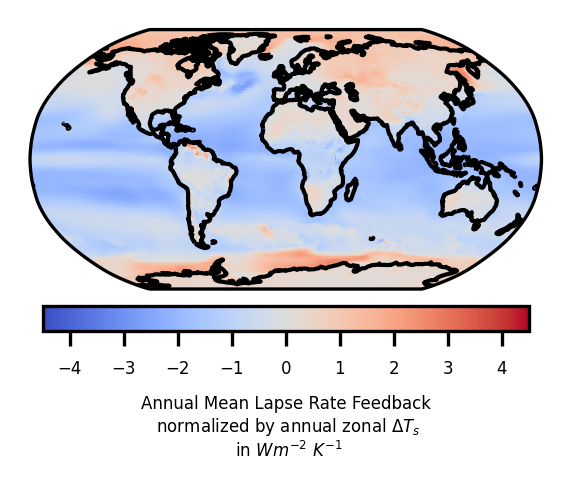

In [14]:
# how to normalize by temperature is debated, here we'll use zonal annual mean delta T
field=LR.mean(dim='time') / ((pert.TS-ctrl.TS).mean(dim='time')).mean(dim='lon')
title='Annual Mean Lapse Rate Feedback\n normalized by annual zonal $\Delta T_s$\n in $W m^{-2}~K^{-1}$'
plotprojection(field,title)

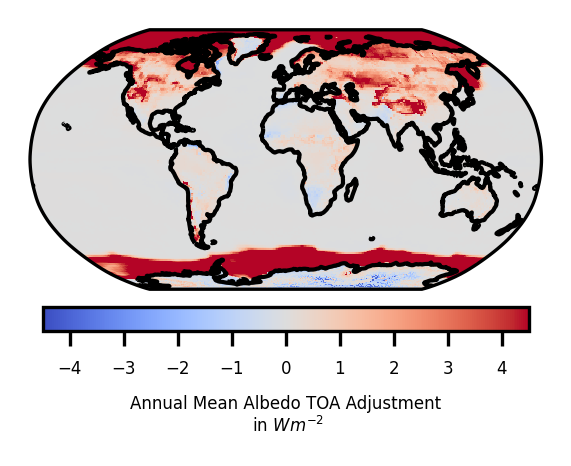

In [15]:
field=Albedo.mean(dim='time')
title='Annual Mean Albedo TOA Adjustment\n in $W m^{-2}$'
plotprojection(field,title)

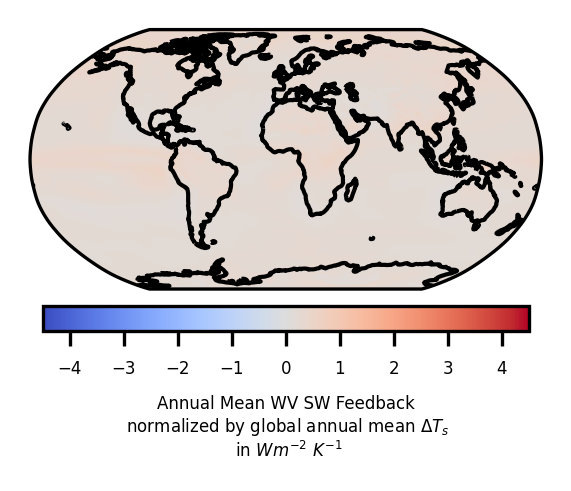

In [16]:
field=sw_q.mean(dim='time')/dTS_glob_avg.mean(dim='time')
title='Annual Mean WV SW Feedback\n normalized by global annual mean $\Delta T_s$\n in $W m^{-2}~K^{-1}$'
plotprojection(field,title)

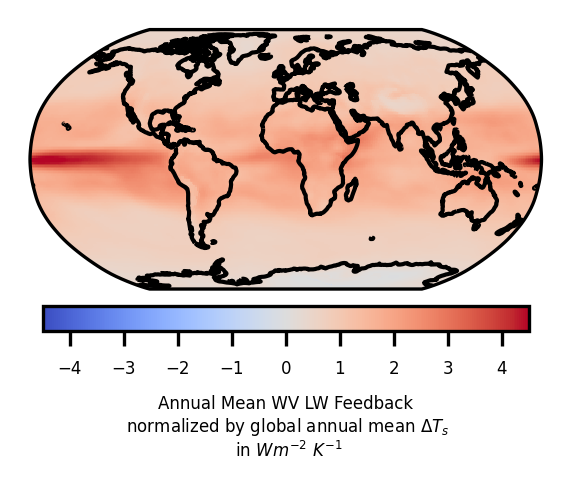

In [17]:
field=lw_q.mean(dim='time')/dTS_glob_avg.mean(dim='time')
title='Annual Mean WV LW Feedback\n normalized by global annual mean $\Delta T_s$\n in $W m^{-2}~K^{-1}$'
plotprojection(field,title)

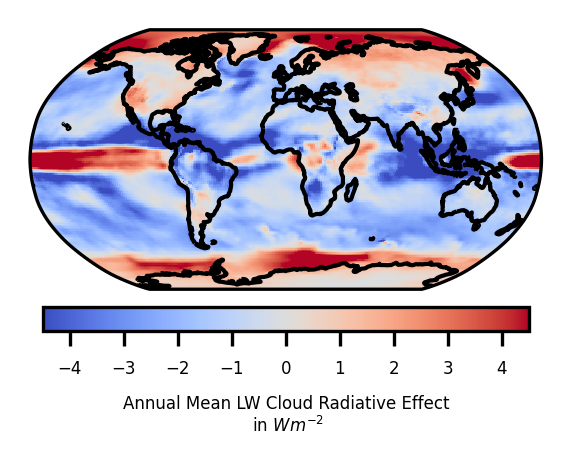

In [18]:
field=dCRE_LW.mean(dim='time')
title='Annual Mean LW Cloud Radiative Effect\n in $W m^{-2}$'
plotprojection(field,title)

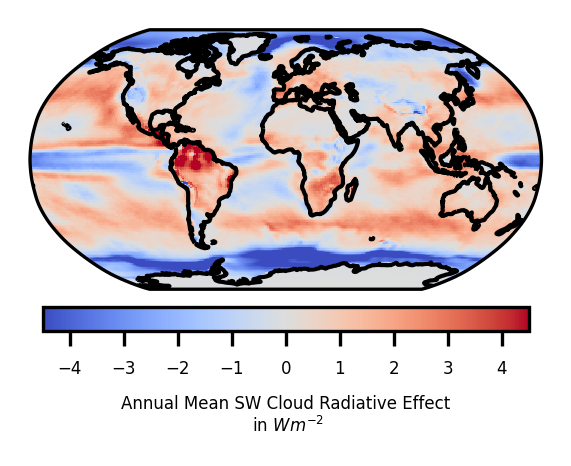

In [19]:
field=dCRE_SW.mean(dim='time')/dTS_glob_avg.mean(dim='time')
title='Annual Mean SW Cloud Radiative Effect\n in $W m^{-2}$'
plotprojection(field,title)

In [16]:
def plotprojection(field,title,vmax):
    # Create figure with PlateCarree projection
    projection = ccrs.Robinson(central_longitude=0)
    transform = ccrs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(1, 1, figsize=(2.2, 1.5), 
        subplot_kw=dict(projection=projection),
        dpi=300)
    mesh = axs.pcolormesh(field.lon.data, field.lat.data, 
                             field.data, cmap='coolwarm',
                             transform=transform, vmin=-vmax, vmax=vmax)
    cbar = plt.colorbar(mesh, ax=axs, orientation='horizontal', shrink=0.95, pad=0.05)
    #cbar.set_label(f'Lapse Rate Adjustment \n in $W m^{-2}$',size=6)
    cbar.set_label(title,size=4)
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_xscale('linear')
    axs.coastlines()
    return


In [ ]:
ncfile='/glade/work/bitz/conda-envs/ck_env/lib/python3.10/site-packages/climkern/data/kernels/GFDL/TOA_GFDL_Kerns.nc'
gfdl=xr.open_mfdataset(ncfile)

In [19]:
gfdl

<xarray.Dataset> Size: 131MB
Dimensions:   (lon: 144, lat: 90, plev: 17, time: 12)
Coordinates:
  * lon       (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * plev      (plev) float64 136B 1e+03 925.0 850.0 700.0 ... 30.0 20.0 10.0
  * time      (time) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    lwclr_q   (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
    PS        (time, lat, lon) float64 1MB dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    lwclr_ts  (time, lat, lon) float32 622kB dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    lwclr_t   (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
    lw_q      (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
    lw_ts     (time, lat, lon) float32 622kB dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    lw_t      (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
    sw_a      (time, lat, lon) float32 622kB dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    swclr_a   (time, lat, lon) float32 622kB dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    swclr_q   (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
    sw_q      (time, plev, lat, lon) float64 21MB dask.array<chunksize=(1, 17, 90, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Thu May  9 23:39:27 2019: ncrename -v lev,plev TOA_GFDL_Ker...
    CDO:          Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/...

In [32]:
def zonalsigma(field, title, vmax):
    fig, ax = plt.subplots( 1, 1, figsize=(5, 4) )
    field.mean(dim='time').mean(dim='lon').plot.pcolormesh(ax=ax, vmin=-vmax, vmax=vmax,cmap="coolwarm")
    #field.mean(dim='time').mean(dim='lon').plot.contourf(ax=ax, vmin=-vmax, vmax=vmax,cmap="coolwarm")

    ax.invert_yaxis()
    ax.set_xticks(np.arange(-90, 120, 30))
    ax.set_title(title)
    ax.set_xticklabels(['90S','60S','30S','0','30N','60N','90N'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Pressure')



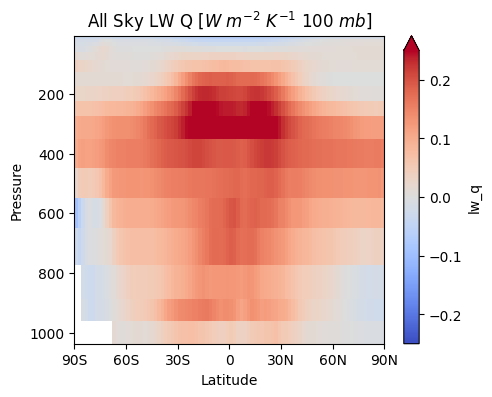

In [74]:
zonalsigma(gfdl['lw_q'],'All Sky LW Q [$W~m^{-2}~K^{-1}~100~mb$]',vmax=.25)

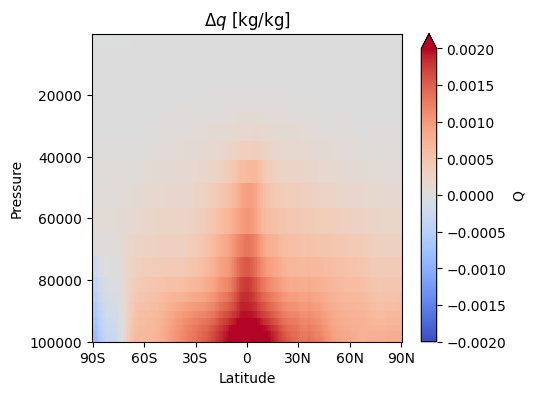

In [73]:
zonalsigma((pert.Q - ctrl.Q),'$\Delta q$ [kg/kg]', vmax=2e-3)

In [ ]:
zonalsigma(gfdl['lw_t'],'Clear Sky LW T [$W~m^{-2}~K^{-1}~100~mb$]',vmax=.5)

In [ ]:
zonalsigma(gfdl['lwclr_t'],'Clear Sky LW T [$W~m^{-2}~K^{-1}~100~mb$]',vmax=.5)

In [ ]:
zonalsigma(gfdl['lw_t'],'All Sky LW T [$W~m^{-2}~K^{-1}~100~mb$]',vmax=.5)

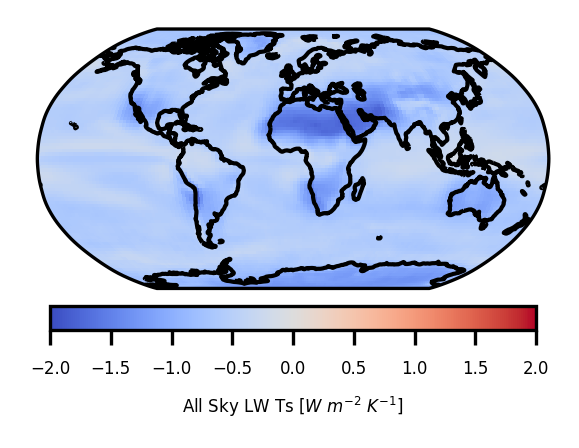

In [18]:
plotprojection(gfdl['lw_ts'].mean(dim='time'),'All Sky LW Ts [$W~m^{-2}~K^{-1}$]',vmax=2)

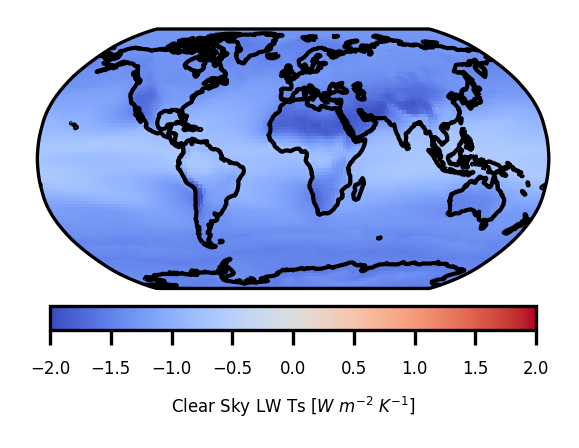

In [21]:
plotprojection(gfdl['lwclr_ts'].mean(dim='time'),'Clear Sky LW Ts [$W~m^{-2}~K^{-1}$]',vmax=2)

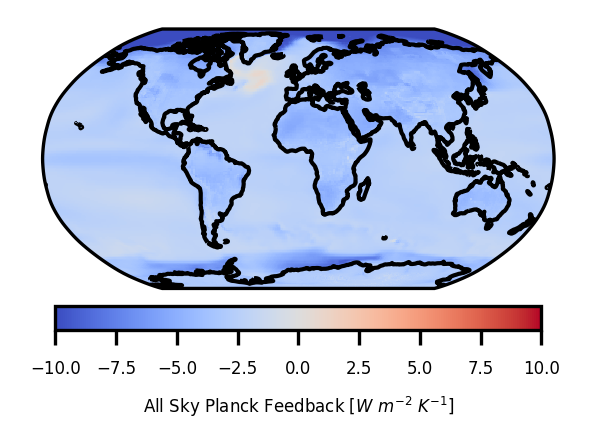

In [49]:
plotprojection((Planck.mean(dim='time')/dTS_glob_avg.mean(dim='time')),'All Sky Planck Feedback [$W~m^{-2}~K^{-1}$]',vmax=10)
#(Planck.mean(dim='time')/dTS_glob_avg.mean(dim='time')).plot()

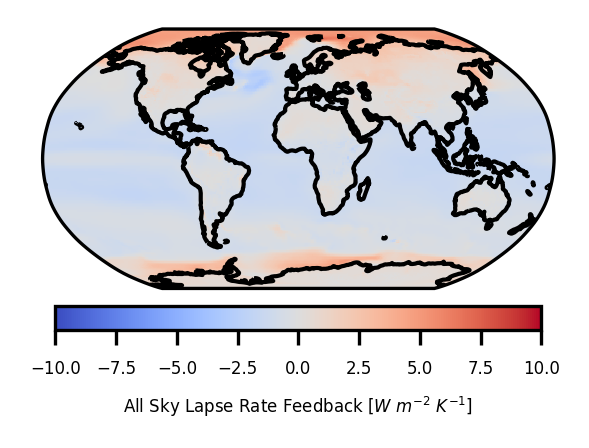

In [50]:
plotprojection((LR.mean(dim='time')/dTS_glob_avg.mean(dim='time')),'All Sky Lapse Rate Feedback [$W~m^{-2}~K^{-1}$]',vmax=10)


In [ ]:
LR,Planck = ck.calc_T_feedbacks(ctrl.T,ctrl.TS,ctrl.PS,
                                pert.T,pert.TS,pert.PS,pert.TROP_P,
                                kern="GFDL")

In [53]:
dTs=pert.TS - ctrl.TS

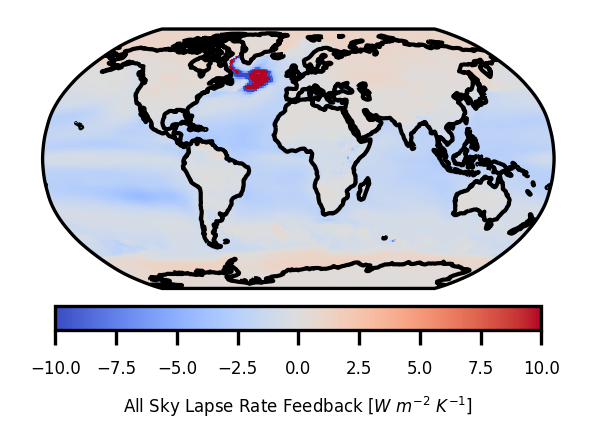

In [55]:
plotprojection((LR.mean(dim='time')/dTs.mean(dim='time')),'All Sky Lapse Rate Feedback [$W~m^{-2}~K^{-1}$]',vmax=10)

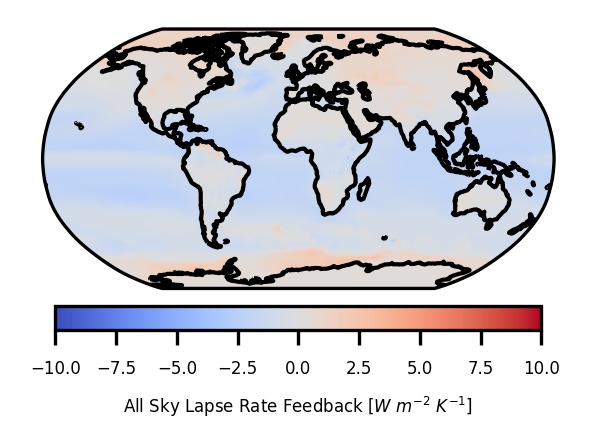

In [57]:
plotprojection((LR.mean(dim='time')/dTs.mean(dim='time').mean(dim='lon')),'All Sky Lapse Rate Feedback [$W~m^{-2}~K^{-1}$]',vmax=10)

In [58]:
plotprojection((WV.mean(dim='time')/dTS_glob_avg.mean(dim='time')),'All Sky Water Vapor Feedback [$W~m^{-2}~K^{-1}$]',vmax=10)


NameError: name 'WV' is not defined